In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
from sklearn.cluster import KMeans

def read(x, y):
    data = pd.read_excel(x, skiprows=y)
    return data, data.transpose()

def poly(x, a, b, c):
    return a*x**2 + b*x + c


def get_error_estimates(x, y, degree):
    coefficients = np.polyfit(x, y, degree)
    y_estimate = np.polyval(coefficients, x)
    residuals = y - y_estimate
    return np.std(residuals)


# specify parameters and call the function to read the excel sheet containing
x = 'API_19_DS2_en_excel_v2_6300761.xls'
y = 3

# call the function to read the data
data, data_transpose = read(x, y)

# creating and cleaning a new dataframe with CO2 emissions for countries
CO2_emission = data[(data['Indicator Name'] == 'CO2 emissions (kt)')]

# drop unnecessary columns and empty fields so we have data for the years
CO2_emission = CO2_emission.drop(['Country Code',
                                  'Indicator Code',
                                  'Indicator Name'], axis=1)
desired_columns = ['Country Name', '1990', '2019']
CO2_emission = CO2_emission[desired_columns]
CO2_emission = CO2_emission.dropna(how='any')
CO2_emission = CO2_emission.set_index('Country Name')

# We need population data for the 2 years so we can calculate CO2 emission
pop = data[(data['Indicator Name'] == 'Population, total')]
pop = pop[desired_columns]
pop = pop[pop['Country Name'].isin(CO2_emission.index)]
pop = pop.set_index('Country Name')

# Calculation CO2 emission per head for each country
CO2_emission['1990'] = CO2_emission['1990']/pop['1990']
CO2_emission['2019'] = CO2_emission['2019']/pop['2019']

# calling the function to read data for GDP per capita
GDP, GDP_transpose = read('API_NY.GDP.PCAP.CD_DS2_en_excel_v2_6298460.xls', 3)

# Cleaning the dataframe to include countries in the CO2 emission dataframe
GDP = GDP[desired_columns]
GDP = GDP[GDP['Country Name'].isin(CO2_emission.index)]
GDP = GDP.set_index('Country Name')

# Creating a new dataframe that has CO2emission per head and GDP per capita
# for the year 1990
data1990 = CO2_emission.drop(['2019'], axis=1)
data1990 = data1990.rename(columns={'1990': 'CO2 Emissions per head'})
data1990['GDP per capita'] = GDP['1990']
data1990 = data1990.dropna(how='any')

# Creating a new dataframe that has CO2emission per head and GDP per capita
# for the year 2019
data2019 = CO2_emission.drop(['1990'], axis=1)
data2019 = data2019.rename(columns={'2019': 'CO2 Emissions per head'})
data2019['GDP per capita'] = GDP['2019']
data2019 = data2019.dropna(how='any')

# visualising data
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(data1990['CO2 Emissions per head'],
               data1990['GDP per capita'], c='blue')
axs[0].set_title('1990')
axs[0].set_xlabel('CO2 emissions per head')
axs[0].set_ylabel('GDP per capita')

axs[1].scatter(data2019['CO2 Emissions per head'],
               data2019['GDP per capita'], c='red')
axs[1].set_title('2019')
axs[1].set_xlabel('CO2 emissions per head')
axs[1].set_ylabel('GDP per capita')
plt.tight_layout()
plt.show()

# Normalize the data using MinMax Normalization method
p1 = data1990[['CO2 Emissions per head', 'GDP per capita']].values
p2 = data2019[['CO2 Emissions per head', 'GDP per capita']].values

max_value1 = p1.max()
min_value1 = p1.min()

max_value2 = p2.max()
min_value2 = p2.min()
# normalized data
p1_norm = (p1 - min_value1) / (max_value1 - min_value1)
p2_norm = (p2 - min_value2) / (max_value2 - min_value2)

sse1 = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++',
                    max_iter=300, n_init=10, random_state=0)
    kmeans.fit(p1_norm)
    sse1.append(kmeans.inertia_)

sse2 = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++',
                    max_iter=300, n_init=10, random_state=0)
    kmeans.fit(p2_norm)
    sse2.append(kmeans.inertia_)

ImportError: Missing optional dependency 'xlrd'. Install xlrd >= 2.0.1 for xls Excel support Use pip or conda to install xlrd.

In [3]:
import seaborn as sns
# Check available styles
print(sns.axes_style())

{'axes.facecolor': 'white', 'axes.edgecolor': 'black', 'axes.grid': False, 'axes.axisbelow': 'line', 'axes.labelcolor': 'black', 'figure.facecolor': 'white', 'grid.color': '#b0b0b0', 'grid.linestyle': '-', 'text.color': 'black', 'xtick.color': 'black', 'ytick.color': 'black', 'xtick.direction': 'out', 'ytick.direction': 'out', 'lines.solid_capstyle': <CapStyle.projecting: 'projecting'>, 'patch.edgecolor': 'black', 'patch.force_edgecolor': False, 'image.cmap': 'viridis', 'font.family': ['sans-serif'], 'font.sans-serif': ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif'], 'xtick.bottom': True, 'xtick.top': False, 'ytick.left': True, 'ytick.right': False, 'axes.spines.left': True, 'axes.spines.bottom': True, 'axes.spines.right': True, 'axes.spines.top': True}


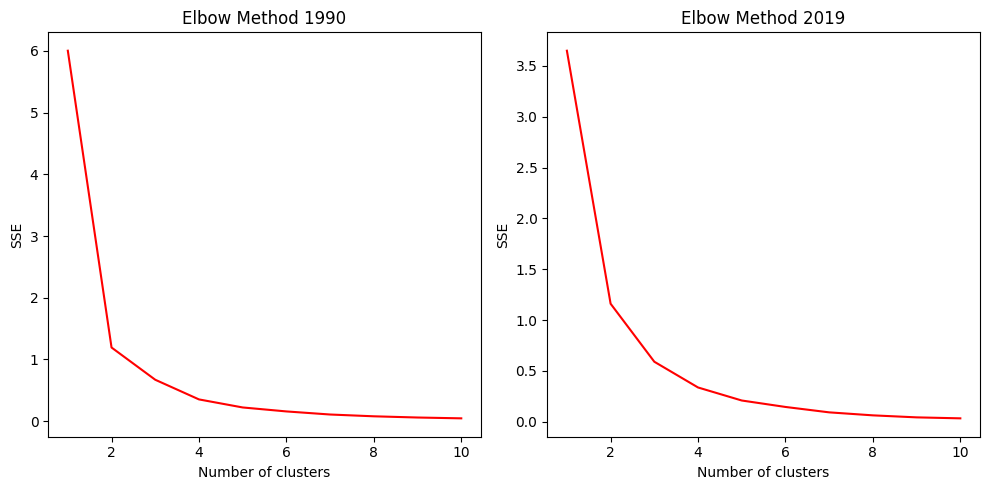

In [17]:
# plotting to check for appropriate number of clusters using elbow method
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(range(1, 11), sse1, color='red')
axs[0].set_title('Elbow Method 1990')
axs[0].set_xlabel('Number of clusters')
axs[0].set_ylabel('SSE')

axs[1].plot(range(1, 11), sse2, color='red')
axs[1].set_title('Elbow Method 2019')
axs[1].set_xlabel('Number of clusters')
axs[1].set_ylabel('SSE')
plt.tight_layout()
plt.show()

In [4]:
# finding the Kmeans clusters
ncluster = 3
kmeans1 = KMeans(n_clusters=ncluster, init='k-means++',
                 max_iter=300, n_init=10, random_state=0)
kmeans2 = KMeans(n_clusters=ncluster, init='k-means++',
                 max_iter=300, n_init=10, random_state=0)

# Fit the model to the data
kmeans1 = kmeans1.fit(p1_norm)
kmeans2 = kmeans2.fit(p2_norm)

# labels
labels1 = kmeans1.labels_
labels2 = kmeans2.labels_

# Extracting clusters centers
cen1 = kmeans1.cluster_centers_
cen2 = kmeans2.cluster_centers_

# Plot the scatter plot of the clusters
# plt.style.use('seaborn')
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=140)
axs[0].scatter(p1_norm[:, 0], p1_norm[:, 1], c=labels1)
axs[0].set_title('K-Means Clustering 1990')
axs[0].set_xlabel('CO2 emissions per head')
axs[0].set_ylabel('GDP per capita')

axs[1].scatter(p2_norm[:, 0], p2_norm[:, 1], c=labels2)
axs[1].set_title('K-Means Clustering 2019')
axs[1].set_xlabel('CO2 emissions per head')
axs[1].set_ylabel('GDP per capita')
plt.tight_layout()
plt.show()

# Getting the Kmeans
kmeans1 = KMeans(n_clusters=ncluster, init='k-means++',
                 max_iter=300, n_init=10, random_state=0)
kmeans2 = KMeans(n_clusters=ncluster, init='k-means++',
                 max_iter=300, n_init=10, random_state=0)
y_predict1 = kmeans1.fit_predict(p1_norm)
y_predict2 = kmeans2.fit_predict(p2_norm)

# creating new dataframe with the labels for each year
data1990['cluster'] = y_predict1
data2019['cluster'] = y_predict2

data1990.to_csv('cluster_results1990.csv')
data2019.to_csv('cluster_results2019.csv')


# plotting the normalised graphs

# plt.style.use('seaborn')
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=140)
axs[0].scatter(p1_norm[y_predict1 == 0, 0], p1_norm[y_predict1 ==
                                                    0, 1], s=50,
               c='lightcoral', label='cluster 0')
axs[0].scatter(p1_norm[y_predict1 == 1, 0], p1_norm[y_predict1 ==
                                                    1, 1], s=50,
               c='tan', label='cluster 1')
axs[0].scatter(p1_norm[y_predict1 == 2, 0], p1_norm[y_predict1 ==
                                                    2, 1], s=50,
               c='orange', label='cluster 2')
axs[0].scatter(cen1[:, 0], cen1[:, 1], s=50, c='black', label='Centroids')
axs[0].set_title(
    'Country clusters based on CO2 emissions and GDP par capita(1990)',
    fontweight='bold', fontsize=8)
axs[0].set_xlabel('CO2 Emissions per head', fontweight='bold')
axs[0].set_ylabel('GDP per capita', fontweight='bold')
axs[0].legend()

axs[1].scatter(p2_norm[y_predict2 == 0, 0], p2_norm[y_predict2 ==
                                                    0, 1], s=50,
               c='lightcoral', label='cluster 0')
axs[1].scatter(p2_norm[y_predict2 == 1, 0], p2_norm[y_predict2 ==
                                                    1, 1], s=50,
               c='tan', label='cluster 1')
axs[1].scatter(p2_norm[y_predict2 == 2, 0], p2_norm[y_predict2 ==
                                                    2, 1], s=50,
               c='orange', label='cluster 2')
axs[1].scatter(cen2[:, 0], cen2[:, 1], s=50, c='black', label='Centroids')
axs[1].set_title(
    'Country clusters based on CO2 emissions and GDP par capita(2019)',
    fontweight='bold', fontsize=8)
axs[1].set_xlabel('CO2 Emissions per head', fontweight='bold')
axs[1].set_ylabel('GDP per capita', fontweight='bold')
axs[1].legend()
plt.tight_layout()

plt.show()

# converting centroid to it's unnormalized form
cent1 = cen1 * (max_value1 - min_value1) + min_value1
cent2 = cen2 * (max_value2 - min_value2) + min_value2

# plotting the Population in their clusters with the centroid points
# plt.style.use('seaborn')
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=600)
axs[0].scatter(p1[y_predict1 == 0, 0], p1[y_predict1 == 0, 1],
               s=50, c='lightcoral', label='Cluster 1')
axs[0].scatter(p1[y_predict1 == 1, 0], p1[y_predict1 == 1, 1],
               s=50, c='tan', label='Cluster 2')
axs[0].scatter(p1[y_predict1 == 2, 0], p1[y_predict1 == 2, 1],
               s=50, c='orange', label='Cluster 3')
axs[0].scatter(cent1[:, 0], cent1[:, 1], s=50, c='black', label='Centroids')
axs[0].set_title(
    'Country clusters based on CO2 emissions and GDP per capita(1990)',
    fontweight='bold', fontsize=9)
axs[0].set_xlabel('CO2 Emissions per head', fontweight='bold', fontsize=8)
axs[0].set_ylabel('GDP per capita', fontweight='bold', fontsize=8)
axs[0].legend()

axs[1].scatter(p2[y_predict2 == 0, 0], p2[y_predict2 == 0, 1],
               s=50, c='lightcoral', label='Cluster 1')
axs[1].scatter(p2[y_predict2 == 1, 0], p2[y_predict2 == 1, 1],
               s=50, c='tan', label='Cluster 2')
axs[1].scatter(p2[y_predict2 == 2, 0], p2[y_predict2 == 2, 1],
               s=50, c='orange', label='Cluster 3')
axs[1].scatter(cent2[:, 0], cent2[:, 1], s=50, c='black', label='Centroids')
axs[1].set_title(
    'Country clusters based on CO2 emissions and GDP per capita(2019)',
    fontweight='bold', fontsize=9)
axs[1].set_xlabel('CO2 Emissions per head', fontweight='bold', fontsize=8)
axs[1].set_ylabel('GDP per capita', fontweight='bold', fontsize=8)
axs[1].legend()
plt.tight_layout()
plt.savefig('Clusters')
plt.show()

# We will now perform GDP/capita curve fitting for a country within
# each cluster (Burundi, Qatar and Luxembourg)

# call the function to read the data
gdp, gdp_transpose = read('API_NY.GDP.PCAP.CD_DS2_en_excel_v2_6298460.xls', 3)

# Clean data and obtain desired columns
gdp = gdp_transpose.drop(['Country Code', 'Indicator Name', 'Indicator Code'])
gdp.columns = gdp.iloc[0, :]
gdp = gdp[1:]
gdp = gdp[gdp.columns[gdp.columns.isin(['Burundi', 'Qatar', 'Luxembourg'])]]
gdp = gdp.dropna(how='any')
gdp['Year'] = gdp.index

# fit data for Burundi
gdp_burundi = gdp[['Year', 'Burundi']].apply(pd.to_numeric, errors='coerce')

# Forecast for the next 20 years
year = np.arange(1970, 2041)

# fits the linear data
param_b, cov_b = opt.curve_fit(poly, gdp_burundi['Year'],
                               gdp_burundi['Burundi'])

# calculate standard deviation
sigma_b = np.sqrt(np.diag(cov_b))

# creates a new column for the fit figures
gdp_burundi['fit'] = poly(gdp_burundi['Year'], *param_b)

# forecasting the fit figures
forecast_b = poly(year, *param_b)

# error estimates
error_b = get_error_estimates(gdp_burundi['Burundi'], gdp_burundi['fit'], 2)
print('\n Error Estimates for Burundi GDP/Capita:\n', error_b)

NameError: name 'p1_norm' is not defined

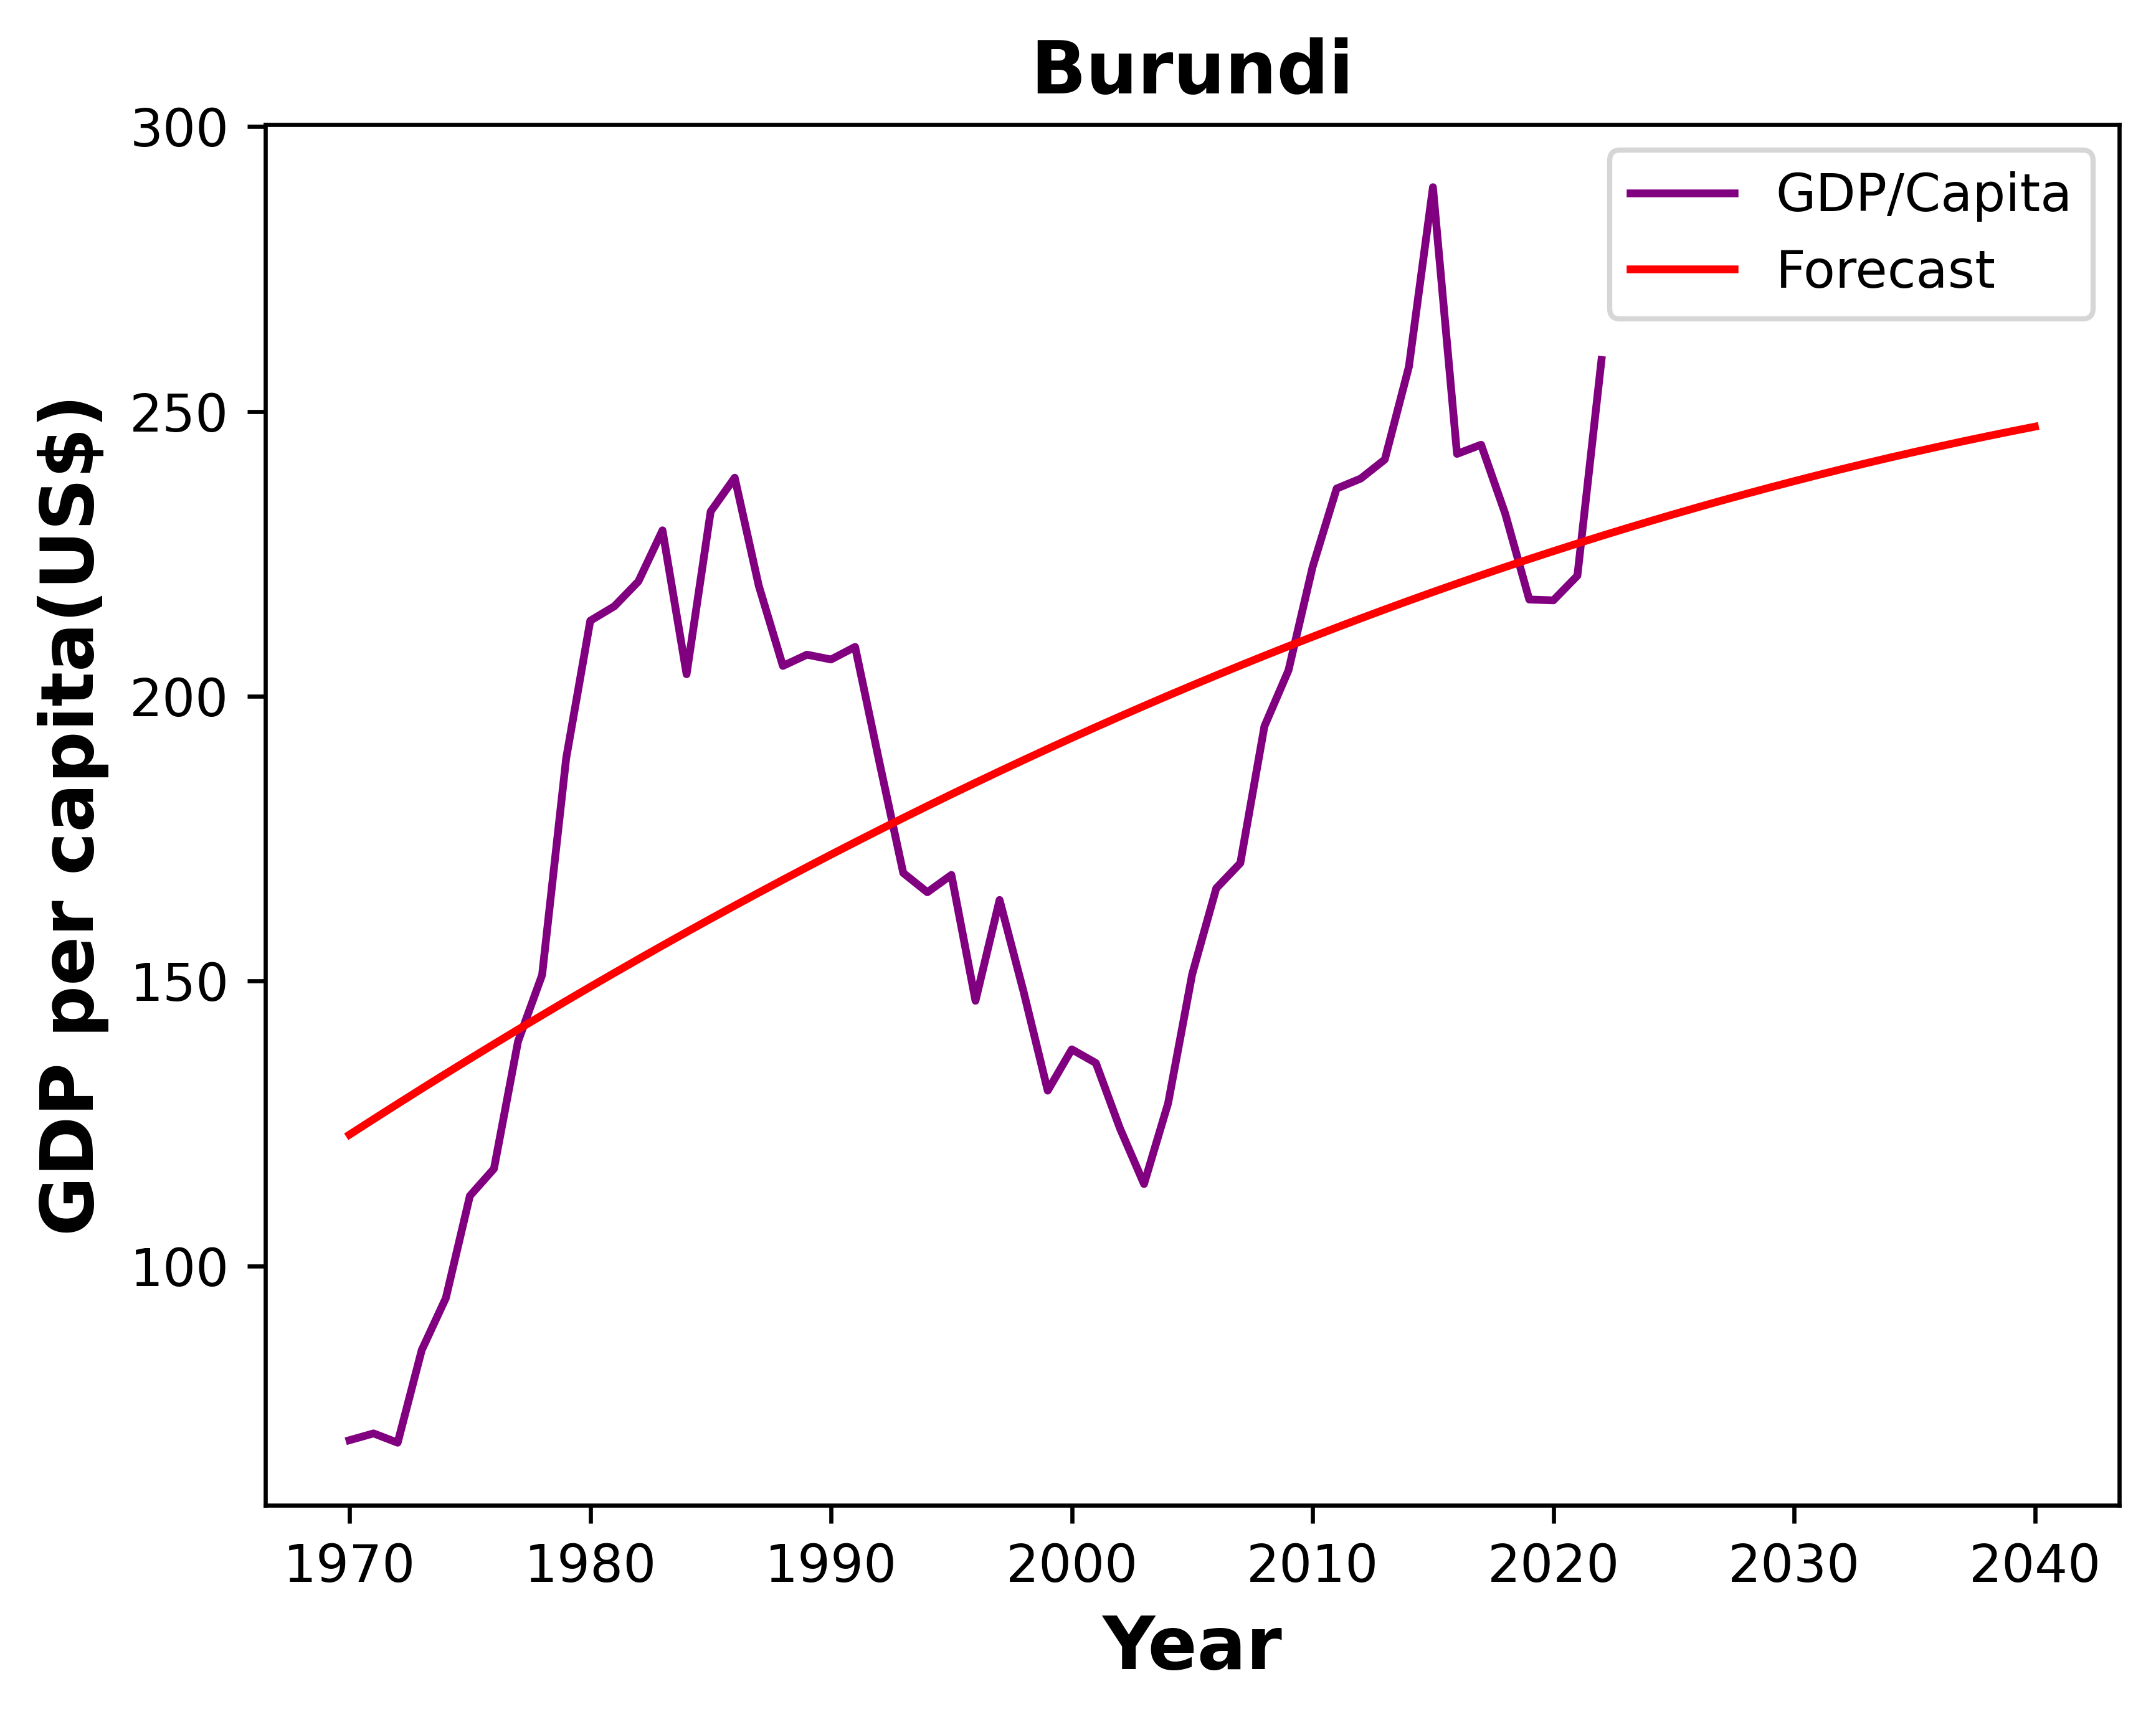


 Error Estimates for Luxembourg GDP/Capita:
 9965.020527120712


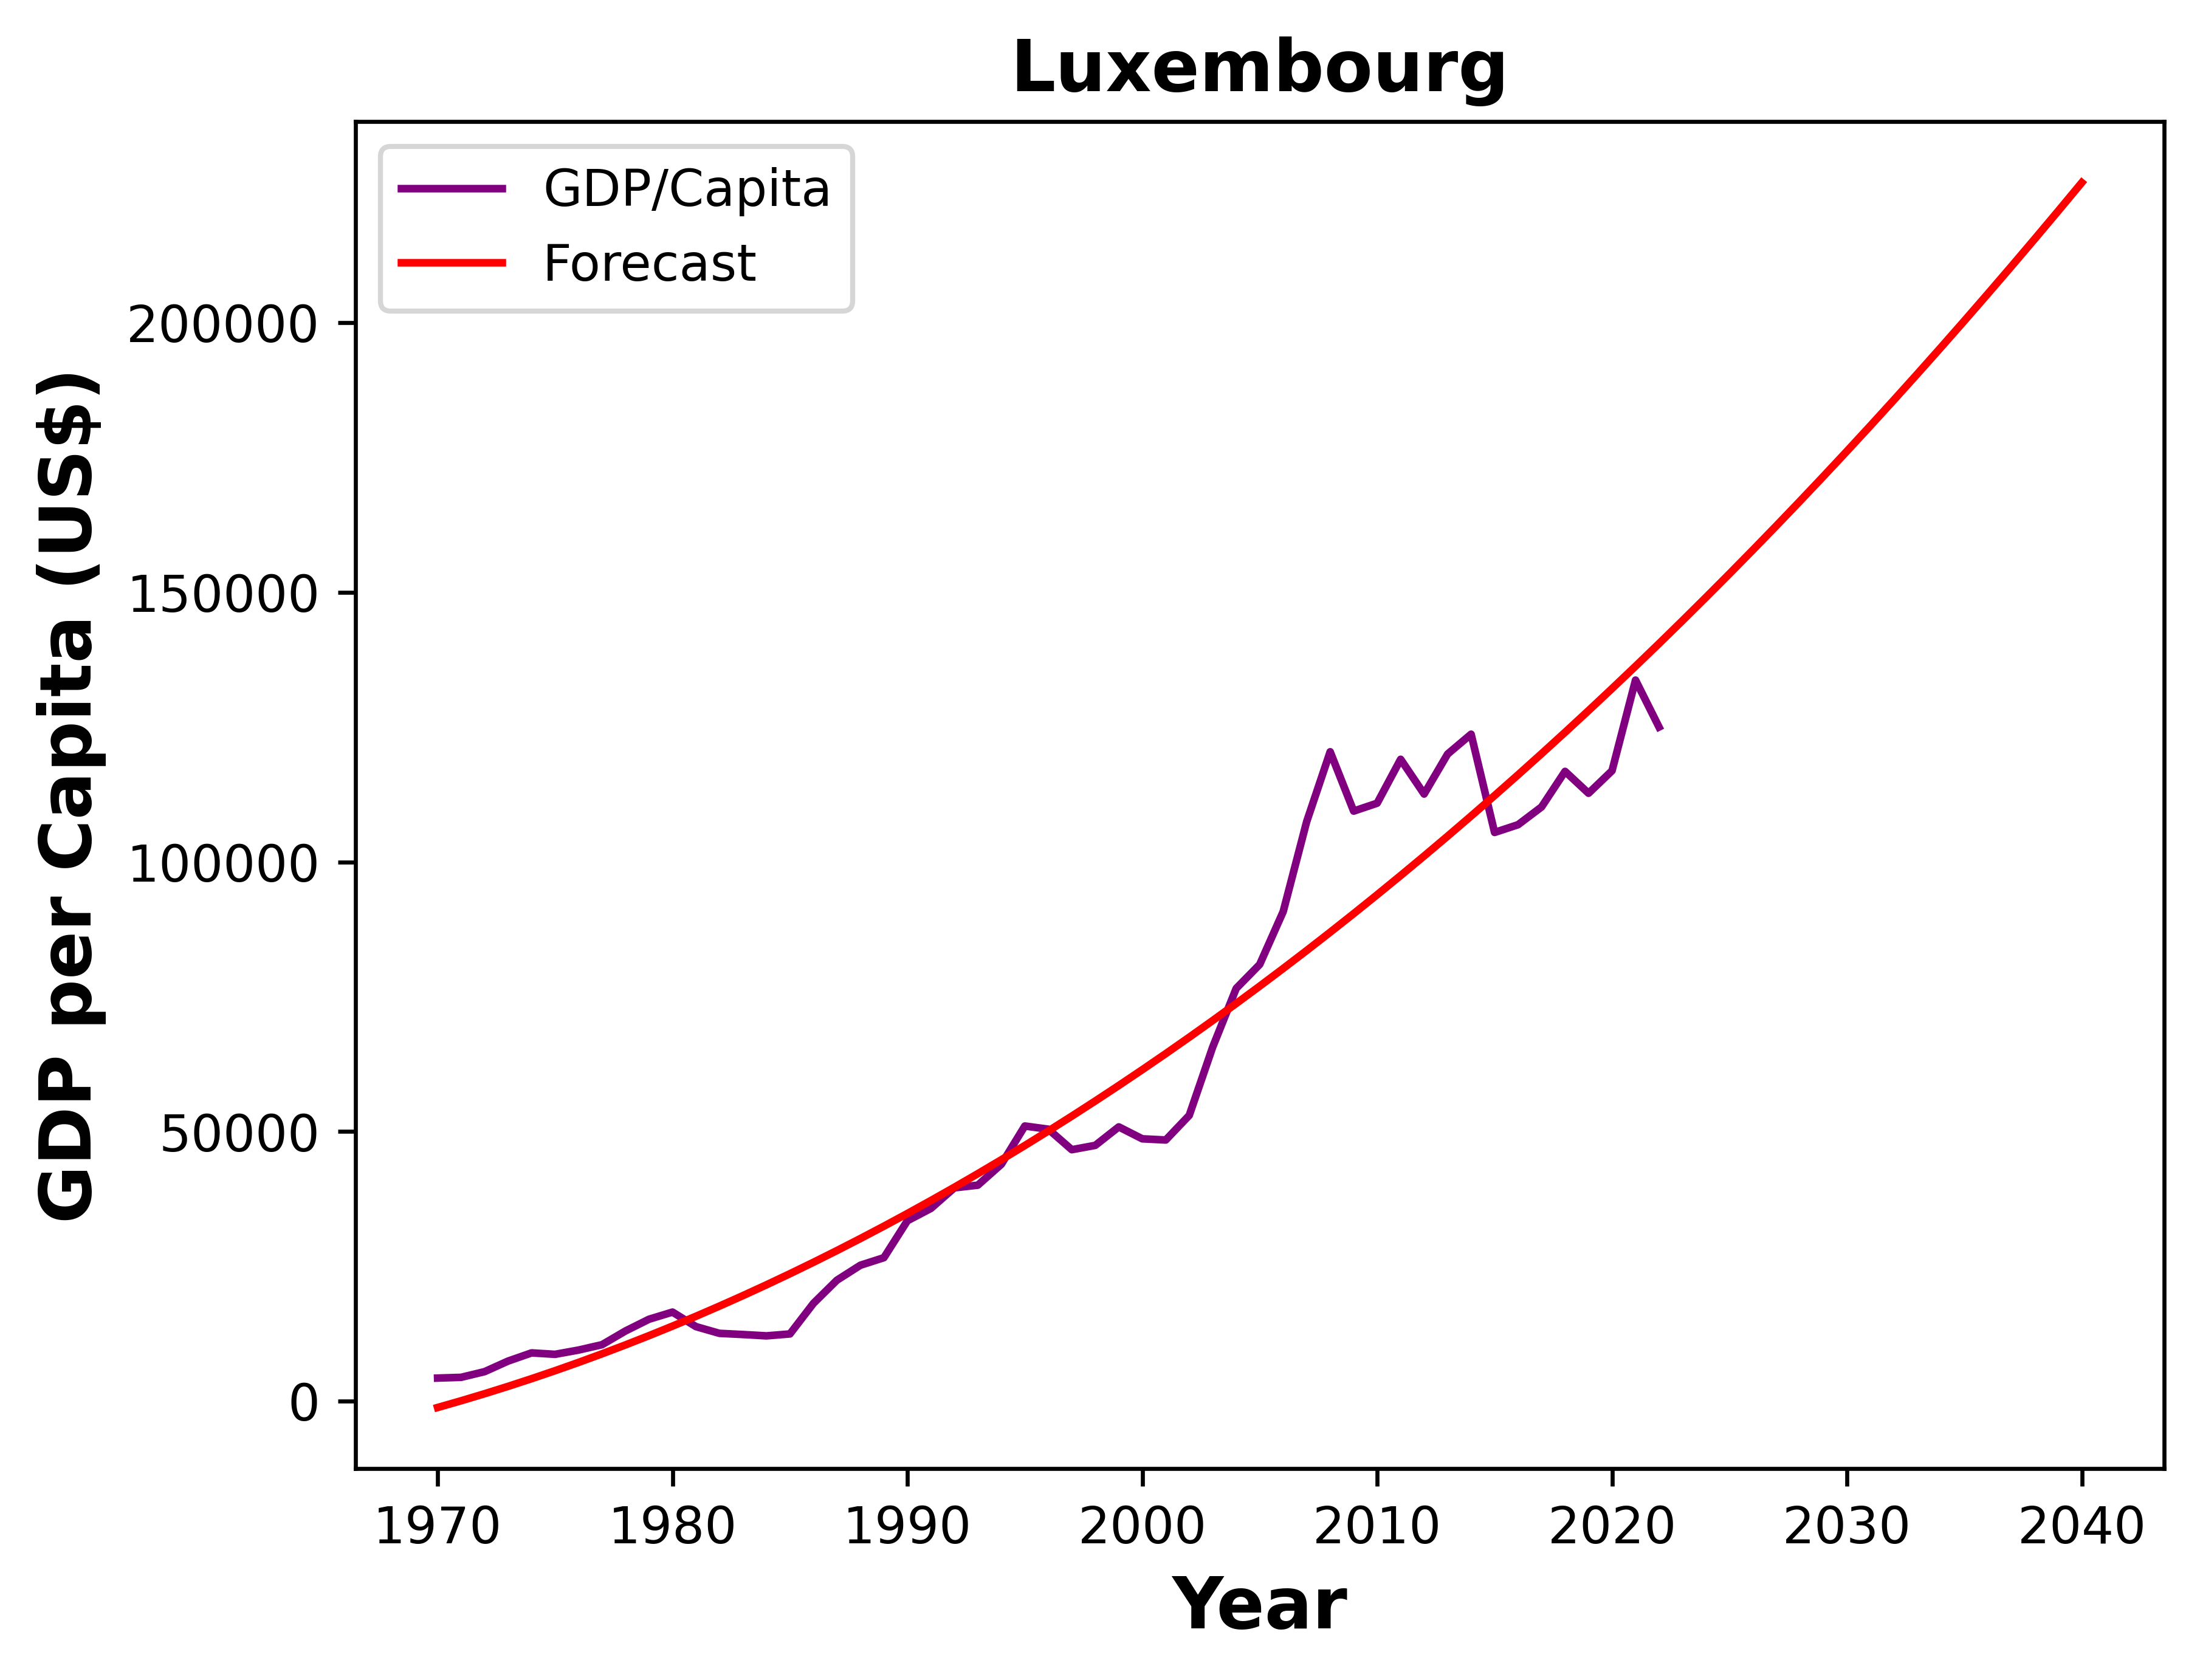

In [20]:
# Plotting the fit
# plt.style.use('seaborn')
plt.figure(dpi=600)
plt.plot(gdp_burundi["Year"], gdp_burundi["Burundi"],
         label="GDP/Capita", c='purple')
plt.plot(year, forecast_b, label="Forecast", c='red')

plt.xlabel("Year", fontweight='bold', fontsize=14)
plt.ylabel("GDP per capita(US$)", fontweight='bold', fontsize=14)
plt.legend()
plt.title('Burundi', fontweight='bold', fontsize=14)
plt.savefig('Burundi.png')
plt.show()

# let's do the same thing for Luxembourg
gdp_lux = gdp[['Year', 'Luxembourg']].apply(pd.to_numeric, errors='coerce')

# fits the linear data
param_lux, cov_lux = opt.curve_fit(poly, gdp_lux['Year'],
                                   gdp_lux['Luxembourg'])

# calculates the standard deviation
sigma_lux = np.sqrt(np.diag(cov_lux))

# creates a column for the fit data
gdp_lux['fit'] = poly(gdp_lux['Year'], *param_lux)

# forecasting for the next 20 years
forecast_lux = poly(year, *param_lux)

# error estimates
error_lux = get_error_estimates(gdp_lux['Luxembourg'], gdp_lux['fit'], 2)
print('\n Error Estimates for Luxembourg GDP/Capita:\n', error_lux)

# Plotting the fit
# plt.style.use('seaborn')
plt.figure(dpi=600)
plt.plot(gdp_lux["Year"], gdp_lux['Luxembourg'], label="GDP/Capita",
         c='purple')
plt.plot(year, forecast_lux, label="Forecast", c='red')
plt.xlabel("Year", fontweight='bold', fontsize=14)
plt.ylabel("GDP per Capita (US$)", fontweight='bold', fontsize=14)
plt.legend()
plt.title('Luxembourg', fontweight='bold', fontsize=14)
plt.savefig('Luxembourg.png')
plt.show()


 Error Estimates for Qatar GDP/Capita:
 10758.568263297704


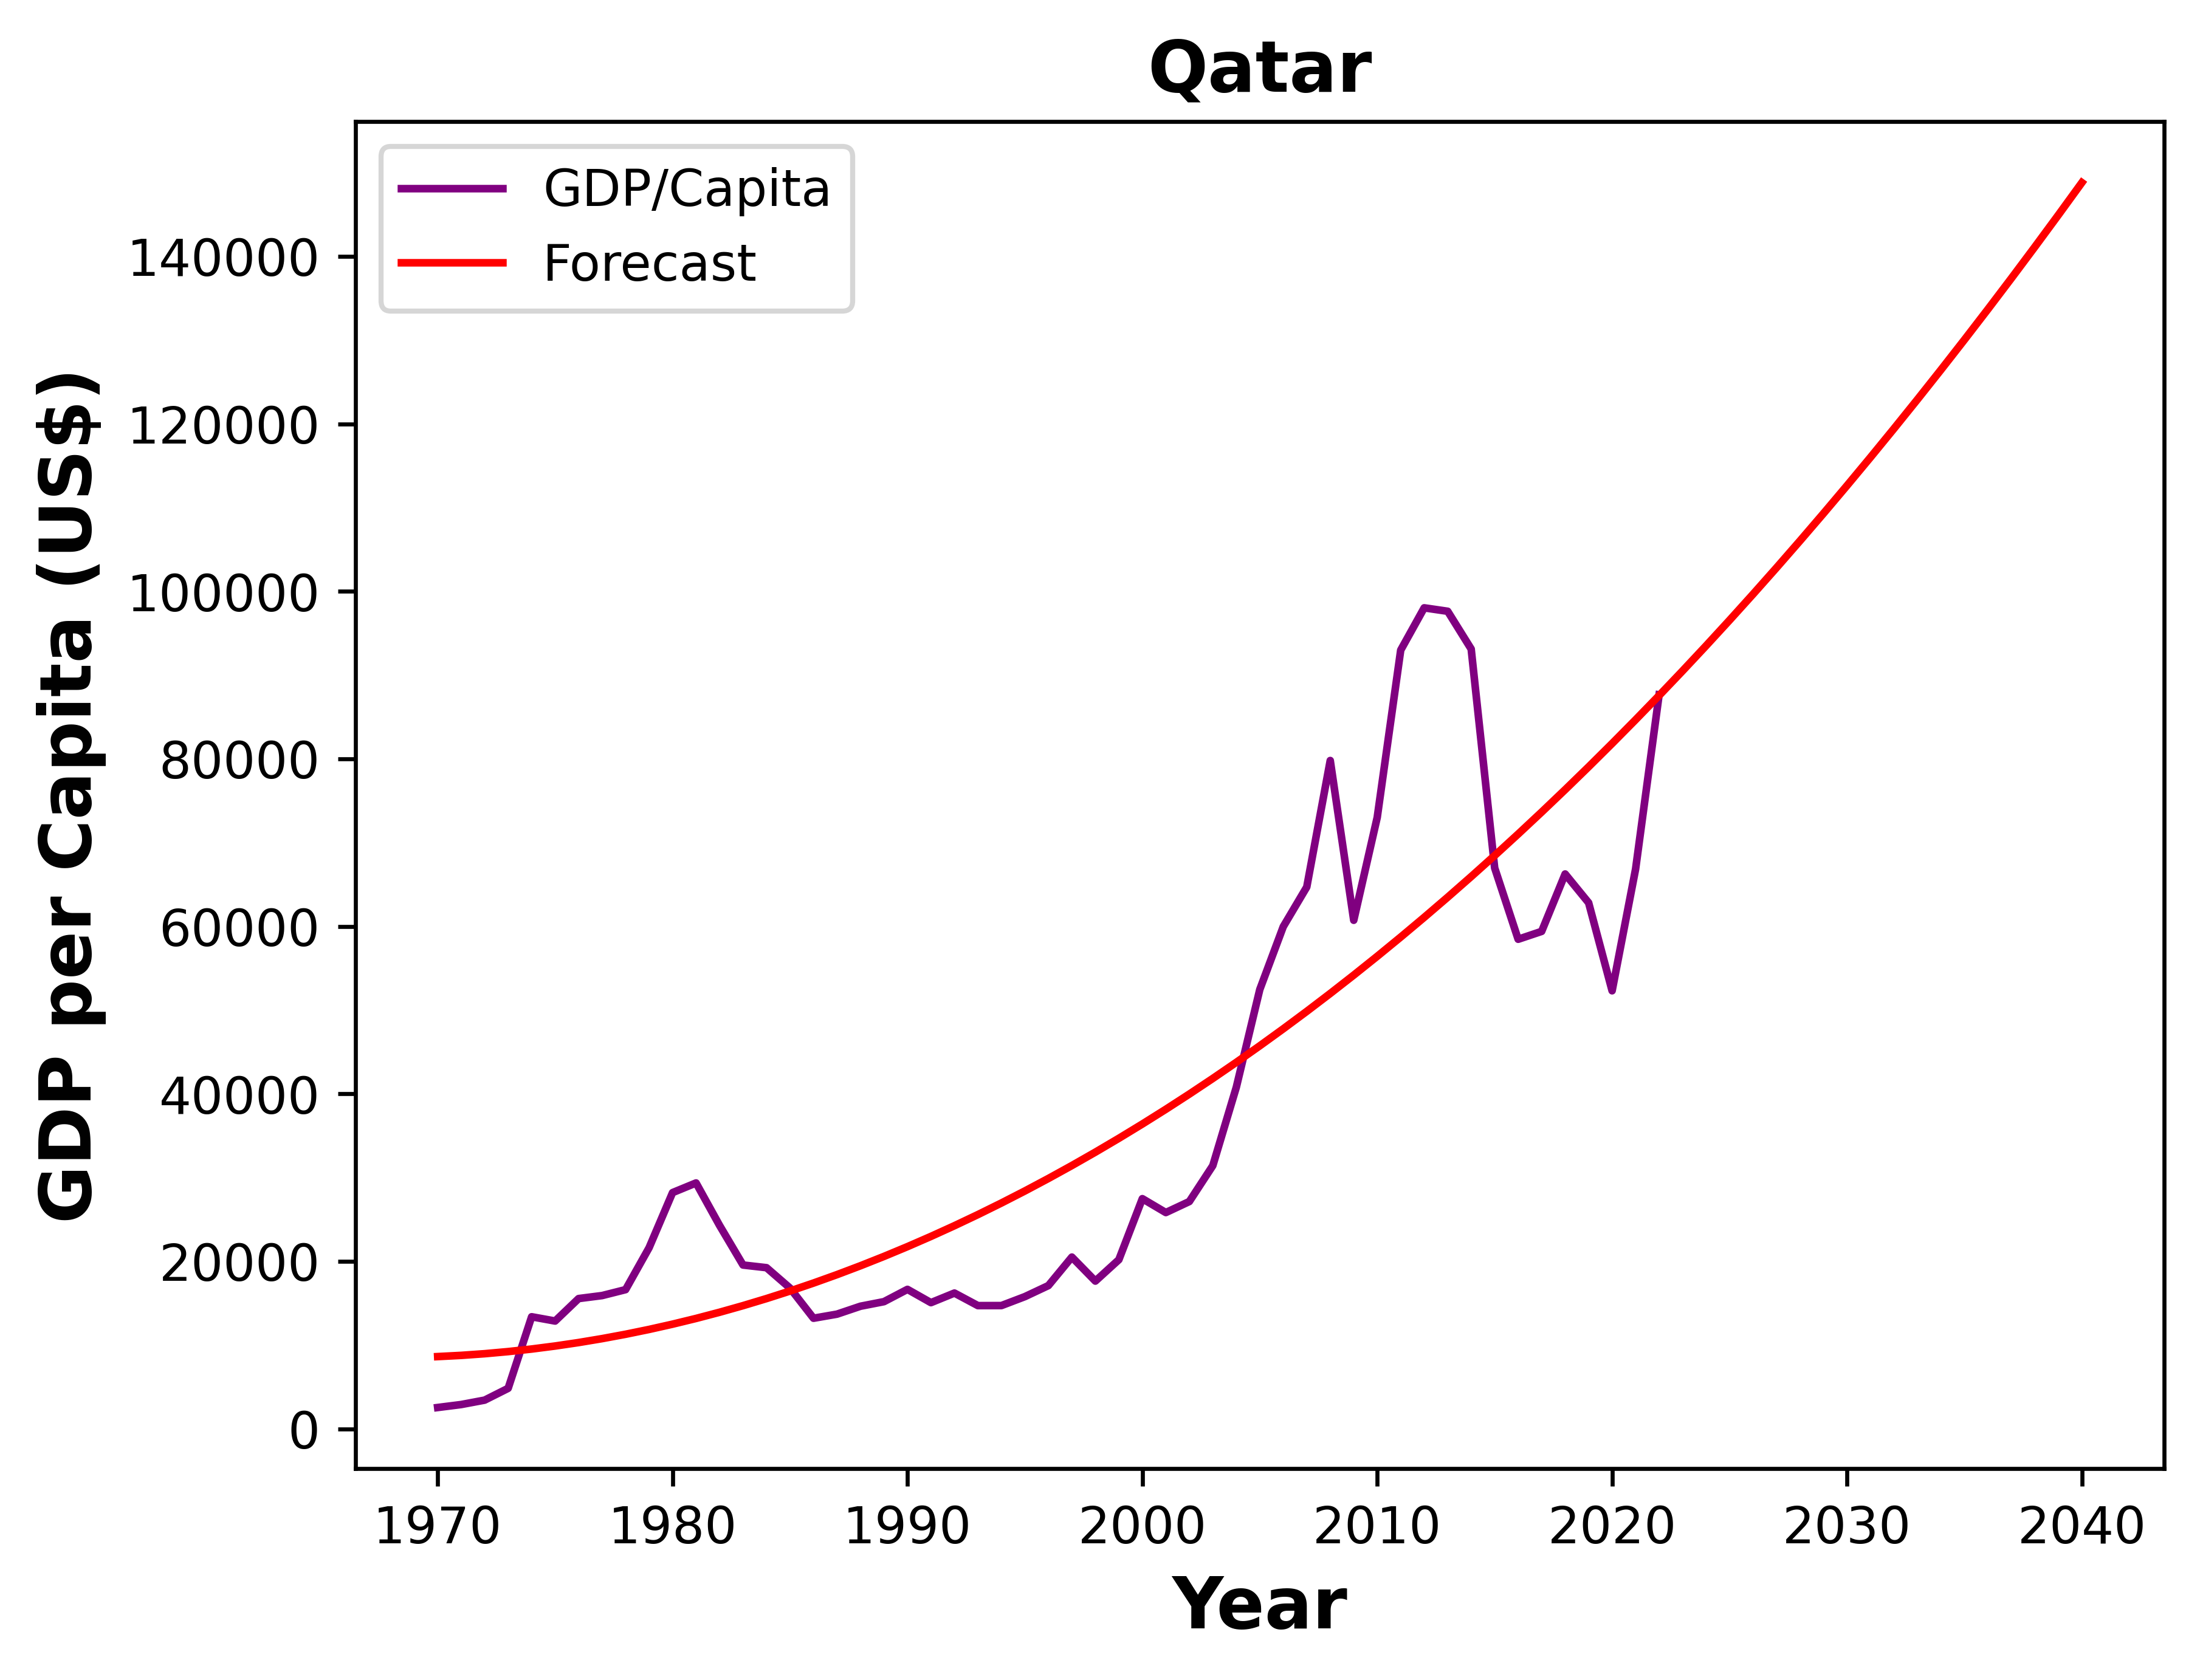

In [28]:
# And lastly for Qatar
gdp_q = gdp[['Year', 'Qatar']].apply(pd.to_numeric, errors='coerce')

# fits the linear data
param_q, cov_q = opt.curve_fit(poly, gdp_q['Year'], gdp_q['Qatar'])

# calculates the standard deviation
sigma_q = np.sqrt(np.diag(cov_q))

# creates a column for the fit data
gdp_q['fit'] = poly(gdp_q['Year'], *param_q)

# forecasting for the next 20 years
forecast_q = poly(year, *param_q)

# error estimates
error_q = get_error_estimates(gdp_q['Qatar'], gdp_q['fit'], 2)
print('\n Error Estimates for Qatar GDP/Capita:\n', error_q)

# Plotting the fit
plt.figure(dpi=600)
plt.plot(gdp_q["Year"], gdp_q['Qatar'], label="GDP/Capita",  c='purple')
plt.plot(year, forecast_q, label="Forecast", c='red')
plt.xlabel("Year", fontweight='bold', fontsize=14)
plt.ylabel("GDP per Capita (US$)", fontweight='bold', fontsize=14)
plt.legend()
plt.title('Qatar', fontweight='bold', fontsize=14)
plt.savefig('Qatar.png')
plt.show()